<div class="markdown-google-sans">

# **The Fabrics Dataset**



## **1. Define problem**


<div class="markdown-google-sans">


The Fabrics Dataset consists of about 2000 samples of garments and fabrics. A small patch of each surface has been captured under 4 different illumination conditions using a custom made, portable photometric stereo sensor. All images have been acquired "in the field" (at clothes shops) and the dataset reflects the distribution of fabrics in real world, hence it is not balanced. The majority of clothes are made of specific fabrics, such as cotton and polyester, while some other fabrics, such as silk and linen, are more rare. Also, a large number of clothes are not composed of a single fabric but two or more fabrics are used to give the garment the desired properties (blended fabrics). For every garment we kept information (attributes) about its material composition from the manufacturer label and its type (pants, shirt, skirt etc.).

https://ibug.doc.ic.ac.uk/resources/fabrics/

In [80]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**2. Prepare Problem**


### **2.1. Load Libraries**

In [81]:
from IPython.display import display, FileLink
from tensorflow.keras.datasets import cifar10, cifar100
from tensorflow.keras import utils, layers, backend as K, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, SpatialDropout2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, TensorBoard

import tensorflow as tf
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

from IPython.display import FileLink
from IPython import display
import pandas as pd

from sklearn.metrics import classification_report
import cv2

from PIL import Image
import os
import shutil
from pathlib import Path

import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model



In [82]:
import random
import tensorboard
from datetime import datetime
from packaging import version
import copy
from PIL import Image

import shutil

In [83]:
#Khai báo thư viện
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [84]:
# Training configurations
SEED_VALUE = 42
BATCH_SIZE = 32
N_EPOCH = 50
N_CLASSES = 7
VERBOSE = 1

# Original dimensions - 400 x 400
IMG_ROWS = 224
IMG_COLS = 224
IMG_CHANNELS = 3




In [85]:
# Seeding everything
tf.random.set_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
random.seed(SEED_VALUE)
tf.compat.v1.set_random_seed(SEED_VALUE)

In [86]:
cur_dir = "/content/drive/MyDrive/Gr3_Fabric_Classification"
INPUT_DATA = f"{cur_dir}/data/Fabrics"


### **2.2. Load Dataset**

In [87]:
# Extracting file input directory and labels
input_filepaths = []
input_labels = []

for index, fabric in enumerate(os.listdir(INPUT_DATA)):
    print("In folder {} \n".format(fabric))
    for fabric_type in os.listdir(os.path.join(INPUT_DATA, fabric)):
        for fabric_img in os.listdir(os.path.join(INPUT_DATA, fabric, fabric_type)):
            if Path(fabric_img).suffix == '.png':
                src_image = os.path.join(INPUT_DATA, fabric, fabric_type, fabric_img)
                input_filepaths.append(src_image)
                input_labels.append(fabric)

In folder Wool 

In folder Silk 

In folder Terrycloth 

In folder Polyester 

In folder Denim 

In folder Leather 

In folder Viscose 

In folder Unclassified 

In folder Linen 

In folder Nylon 

In folder Fur 

In folder Satin 

In folder Fleece 

In folder Lut 

In folder Felt 

In folder Crepe 

In folder Velvet 

In folder Suede 

In folder Utilities 

In folder Acrylic 

In folder Artificial_fur 

In folder Artificial_leather 

In folder Blended 

In folder Chenille 

In folder Corduroy 

In folder Cotton 



## **3. Exploration Analyze Data - EDA**

In [88]:
data_df = pd.DataFrame(list(zip(input_filepaths, input_labels)), columns =['Filepath', 'Label'])
data_df

,Filepath,Label
0,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
1,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
2,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
3,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
4,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
...,...,...
7876,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
7877,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
7878,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
7879,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton


In [89]:

values, counts = np.unique(input_labels, return_counts=True)

class_distribution_df = pd.DataFrame({
    'Class': values,
    'Frequency': counts
})

class_distribution_df = class_distribution_df.sort_values('Frequency', ascending=False)

print("Class distribution info:\n")
print(class_distribution_df.info())  # Hiển thị thông tin cấu trúc của DataFrame
print("\nClass distribution details:\n")
print(class_distribution_df)  # Hiển thị chi tiết về sự phân bố của các lớp


Class distribution info:

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 6 to 21
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Class      25 non-null     object
 1   Frequency  25 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 600.0+ bytes
None

Class distribution details:

                 Class  Frequency
6               Cotton       2352
3              Blended       1645
15           Polyester        904
8                Denim        648
20        Unclassified        492
24                Wool        360
14               Nylon        228
17                Silk        200
23             Viscose        148
10              Fleece        132
19          Terrycloth        120
7                Crepe        104
5             Corduroy         96
16               Satin         96
12               Linen         76
11             Leather         64
4             Chenille         52
0              Acry

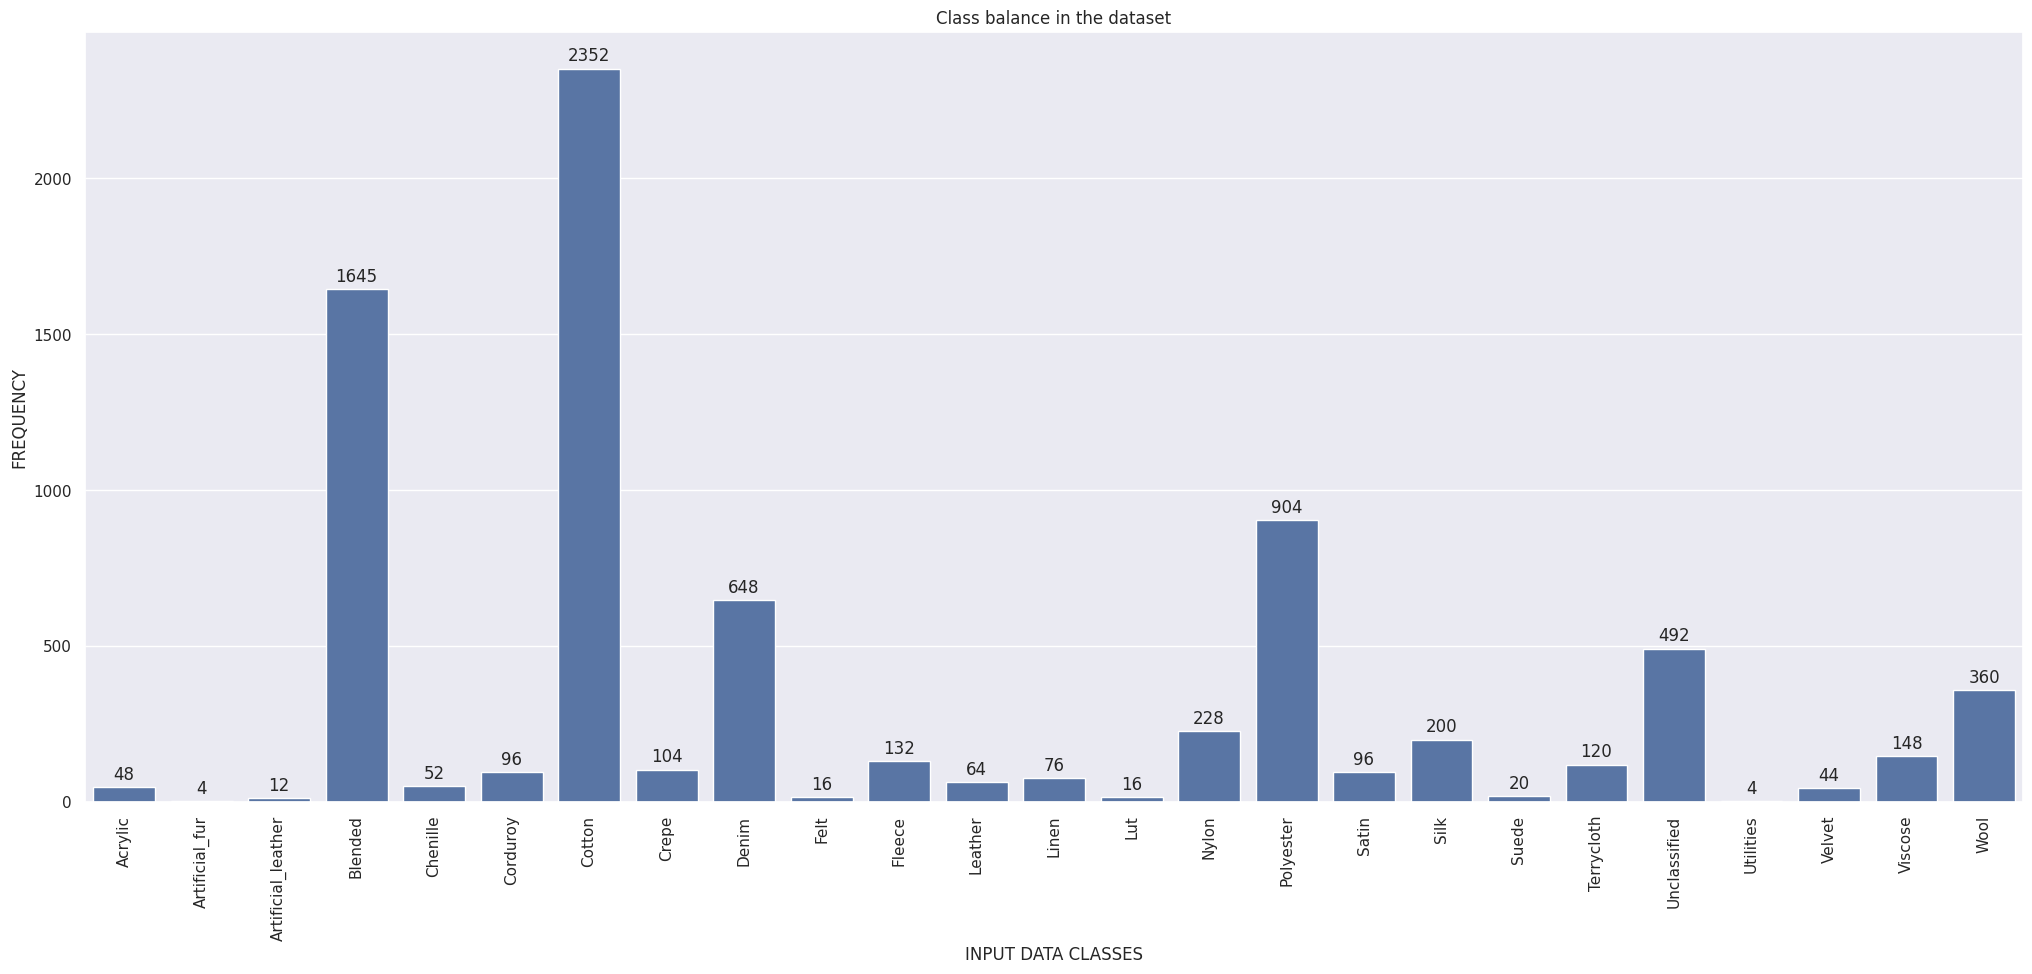

In [90]:
fig, ax = plt.subplots(figsize=(25,10))
values, counts = np.unique(input_labels, return_counts=True)
sns.set_theme()
ax = sns.barplot(x=values, y=counts)
ax.set_title("Class balance in the dataset")
ax.set_xlabel("INPUT DATA CLASSES")
ax.set_ylabel("FREQUENCY")
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

plt.xticks(rotation=90)
plt.show()

<div class="markdown-google-sans">

**Nhận xét:**


---


- **Mất cân bằng giữa các lớp**: Có sự chênh lệch lớn về số lượng mẫu giữa các lớp. Một số lớp như **"Blended"** (1,645 mẫu), **"Cotton"** (2,352 mẫu), và **"Polyester"** (904 mẫu) có số lượng mẫu rất lớn, trong khi nhiều lớp khác như **"Artificial_fur", "Utilities",** và **"Suede"** chỉ có vài mẫu (4-20 mẫu). Điều này cho thấy dữ liệu không cân bằng, với một số lớp bị thiếu mẫu nghiêm trọng.

- Dữ liệu tập trung vào các lớp dữ liệu như "blended", "cotton", "denim" -> cần áp dụng các kĩ thuật như sampling (over-sampling, under-sampling) hoặc điều chỉnh trọng số khi huấn luyện mô hình. Bên cạnh đó các lớp như "Artificial_fur", "Utilities", "Suede" có rất ít mẫu, điều này có thể dẫn đến việc mô hình không học được đặc trưng của các lớp này.

- Blended (Vải pha)là loại vải kết hợp từ 2 hay nhiều loại vải khác nhau như Cotton và Polyester... Trong thí nghiệm này, chúng ta sẽ không sử dụng các loại quần áo làm từ vải pha trộn mà chỉ giữ lại những loại vải có thành phần 95% là một loại vật liệu.

- Lớp "Unclassified" chiếm số lượng đáng kể trong dữ liệu và bao gồm các mẫu vải chưa được phân loại rõ ràng. Điều này tạo ra thách thức cho mô hình học máy do tính không đồng nhất, nhưng cũng mở ra cơ hội để khám phá các loại vải mới. Cần xử lý lớp này cẩn thận để tránh ảnh hưởng tiêu cực đến hiệu suất mô hình.

 => Để đảm bảo mô hình học máy hoạt động hiệu quả trên tất cả các lớp,phần tiếp theo cần thực hiện một số bước như c**ân bằng dữ liệu, hoặc sử dụng các phương pháp học máy mạnh hơn (như kỹ thuật tăng cường) để xử lý dữ liệu không cân bằng.**









## **4. Preprocessing**

<div class="markdown-google-sans">

### ***4.1. Removing fabrics with very low sample size***


In [91]:
data_df = data_df.loc[data_df['Label'].isin(["Cotton", "Denim", "Polyester", "Nylon", "Silk", "Wool"])]
data_df = data_df.reset_index(drop=True)
data_df

,Filepath,Label
0,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
1,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
2,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
3,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
4,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
...,...,...
4687,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
4688,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
4689,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
4690,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton


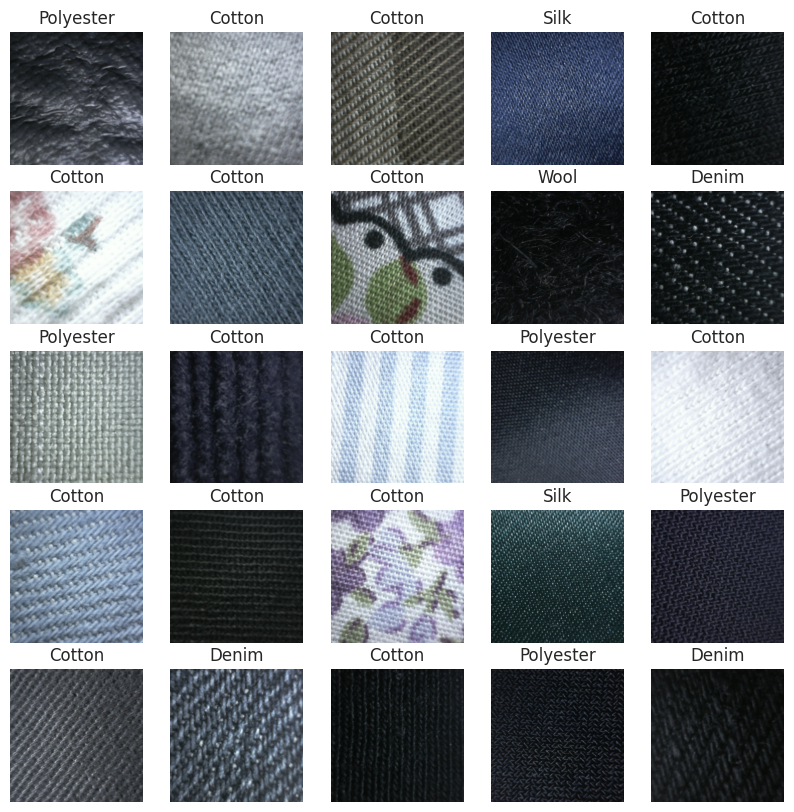

In [92]:
random_index = np.random.randint(0, len(data_df), 25)
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    ax.imshow(plt.imread(data_df.Filepath[random_index[i]]))
    ax.set_title(data_df.Label[random_index[i]])
    plt.axis('off')
plt.show()

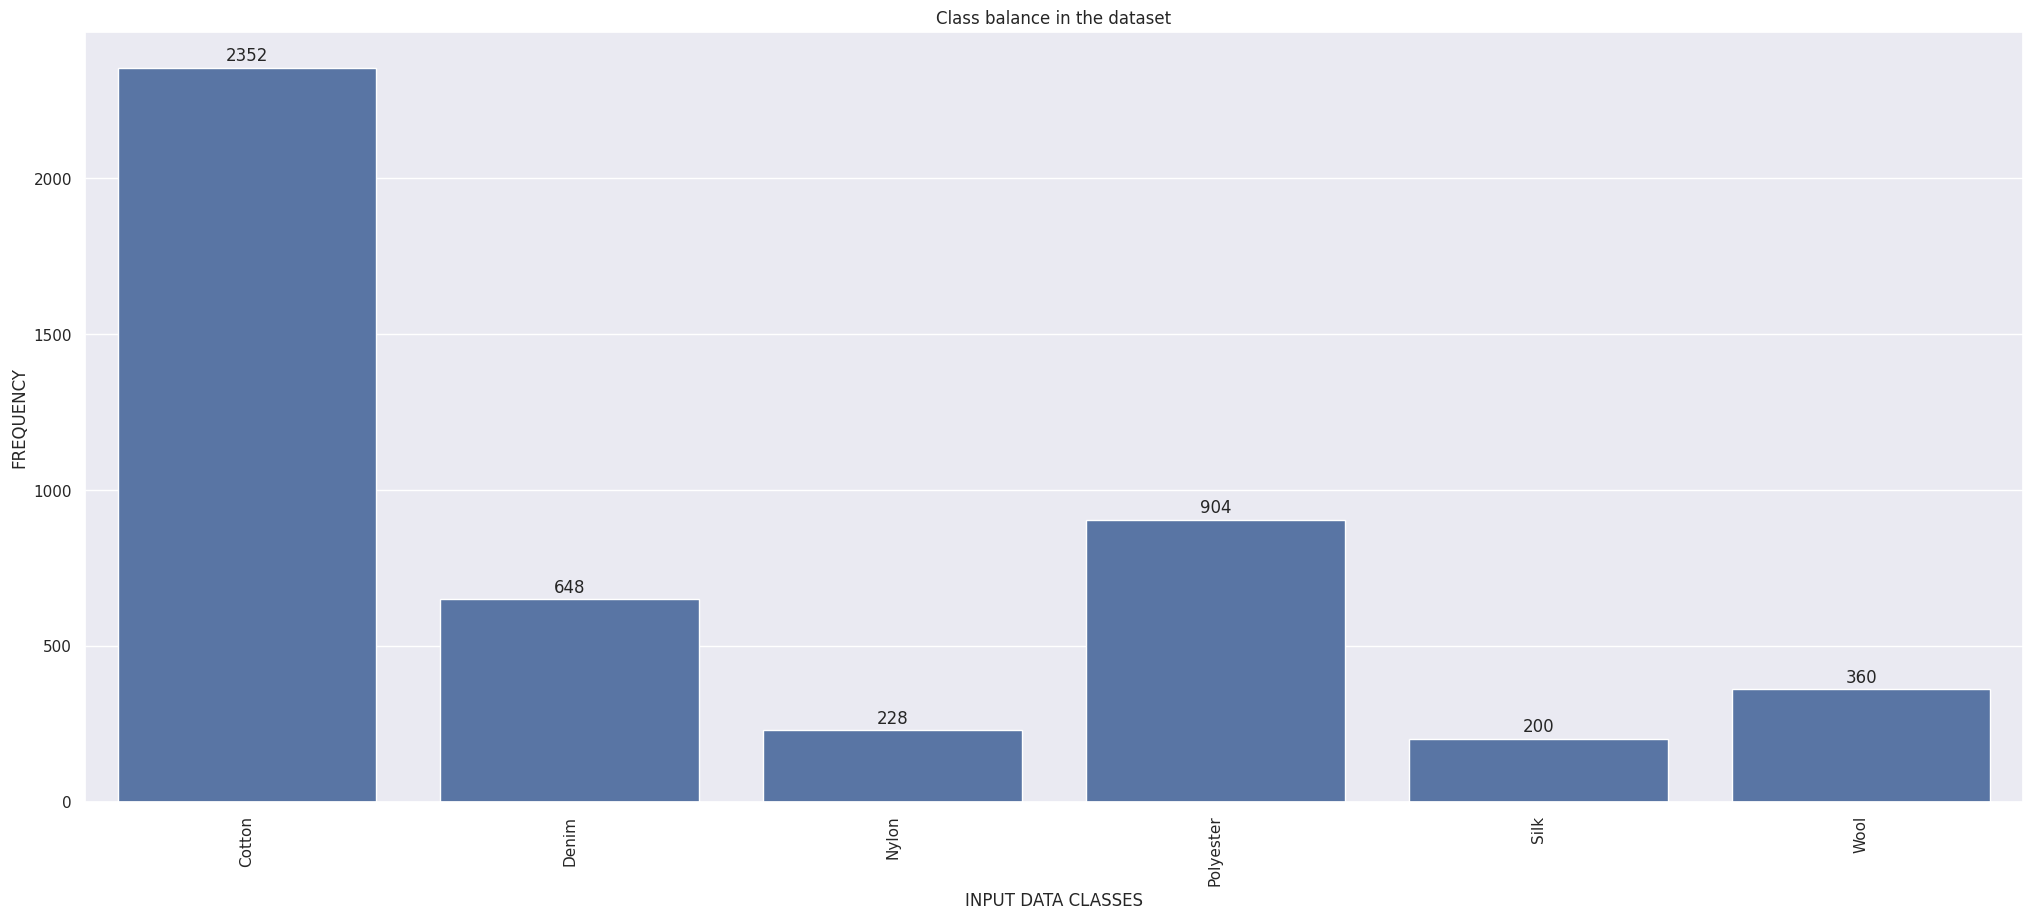

In [93]:
fig, ax = plt.subplots(figsize=(25,10))
values, counts = np.unique(data_df.Label.values.tolist(), return_counts=True)
sns.set_theme()
ax = sns.barplot(x=values, y=counts)
ax.set_title("Class balance in the dataset")
ax.set_xlabel("INPUT DATA CLASSES")
ax.set_ylabel("FREQUENCY")
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

plt.xticks(rotation=90)
plt.show()

<div class="markdown-google-sans">

### 4.2. Improving the class balance through **Data Augmentation**


Multi Step Augmentation to improve class balance. We perform this augmentation only on the training data, retaining the original fabric samples in the test dataset.



In [94]:
train_df, test_df = train_test_split(data_df, test_size=0.2, stratify=data_df[['Label']], shuffle=True, random_state=SEED_VALUE)

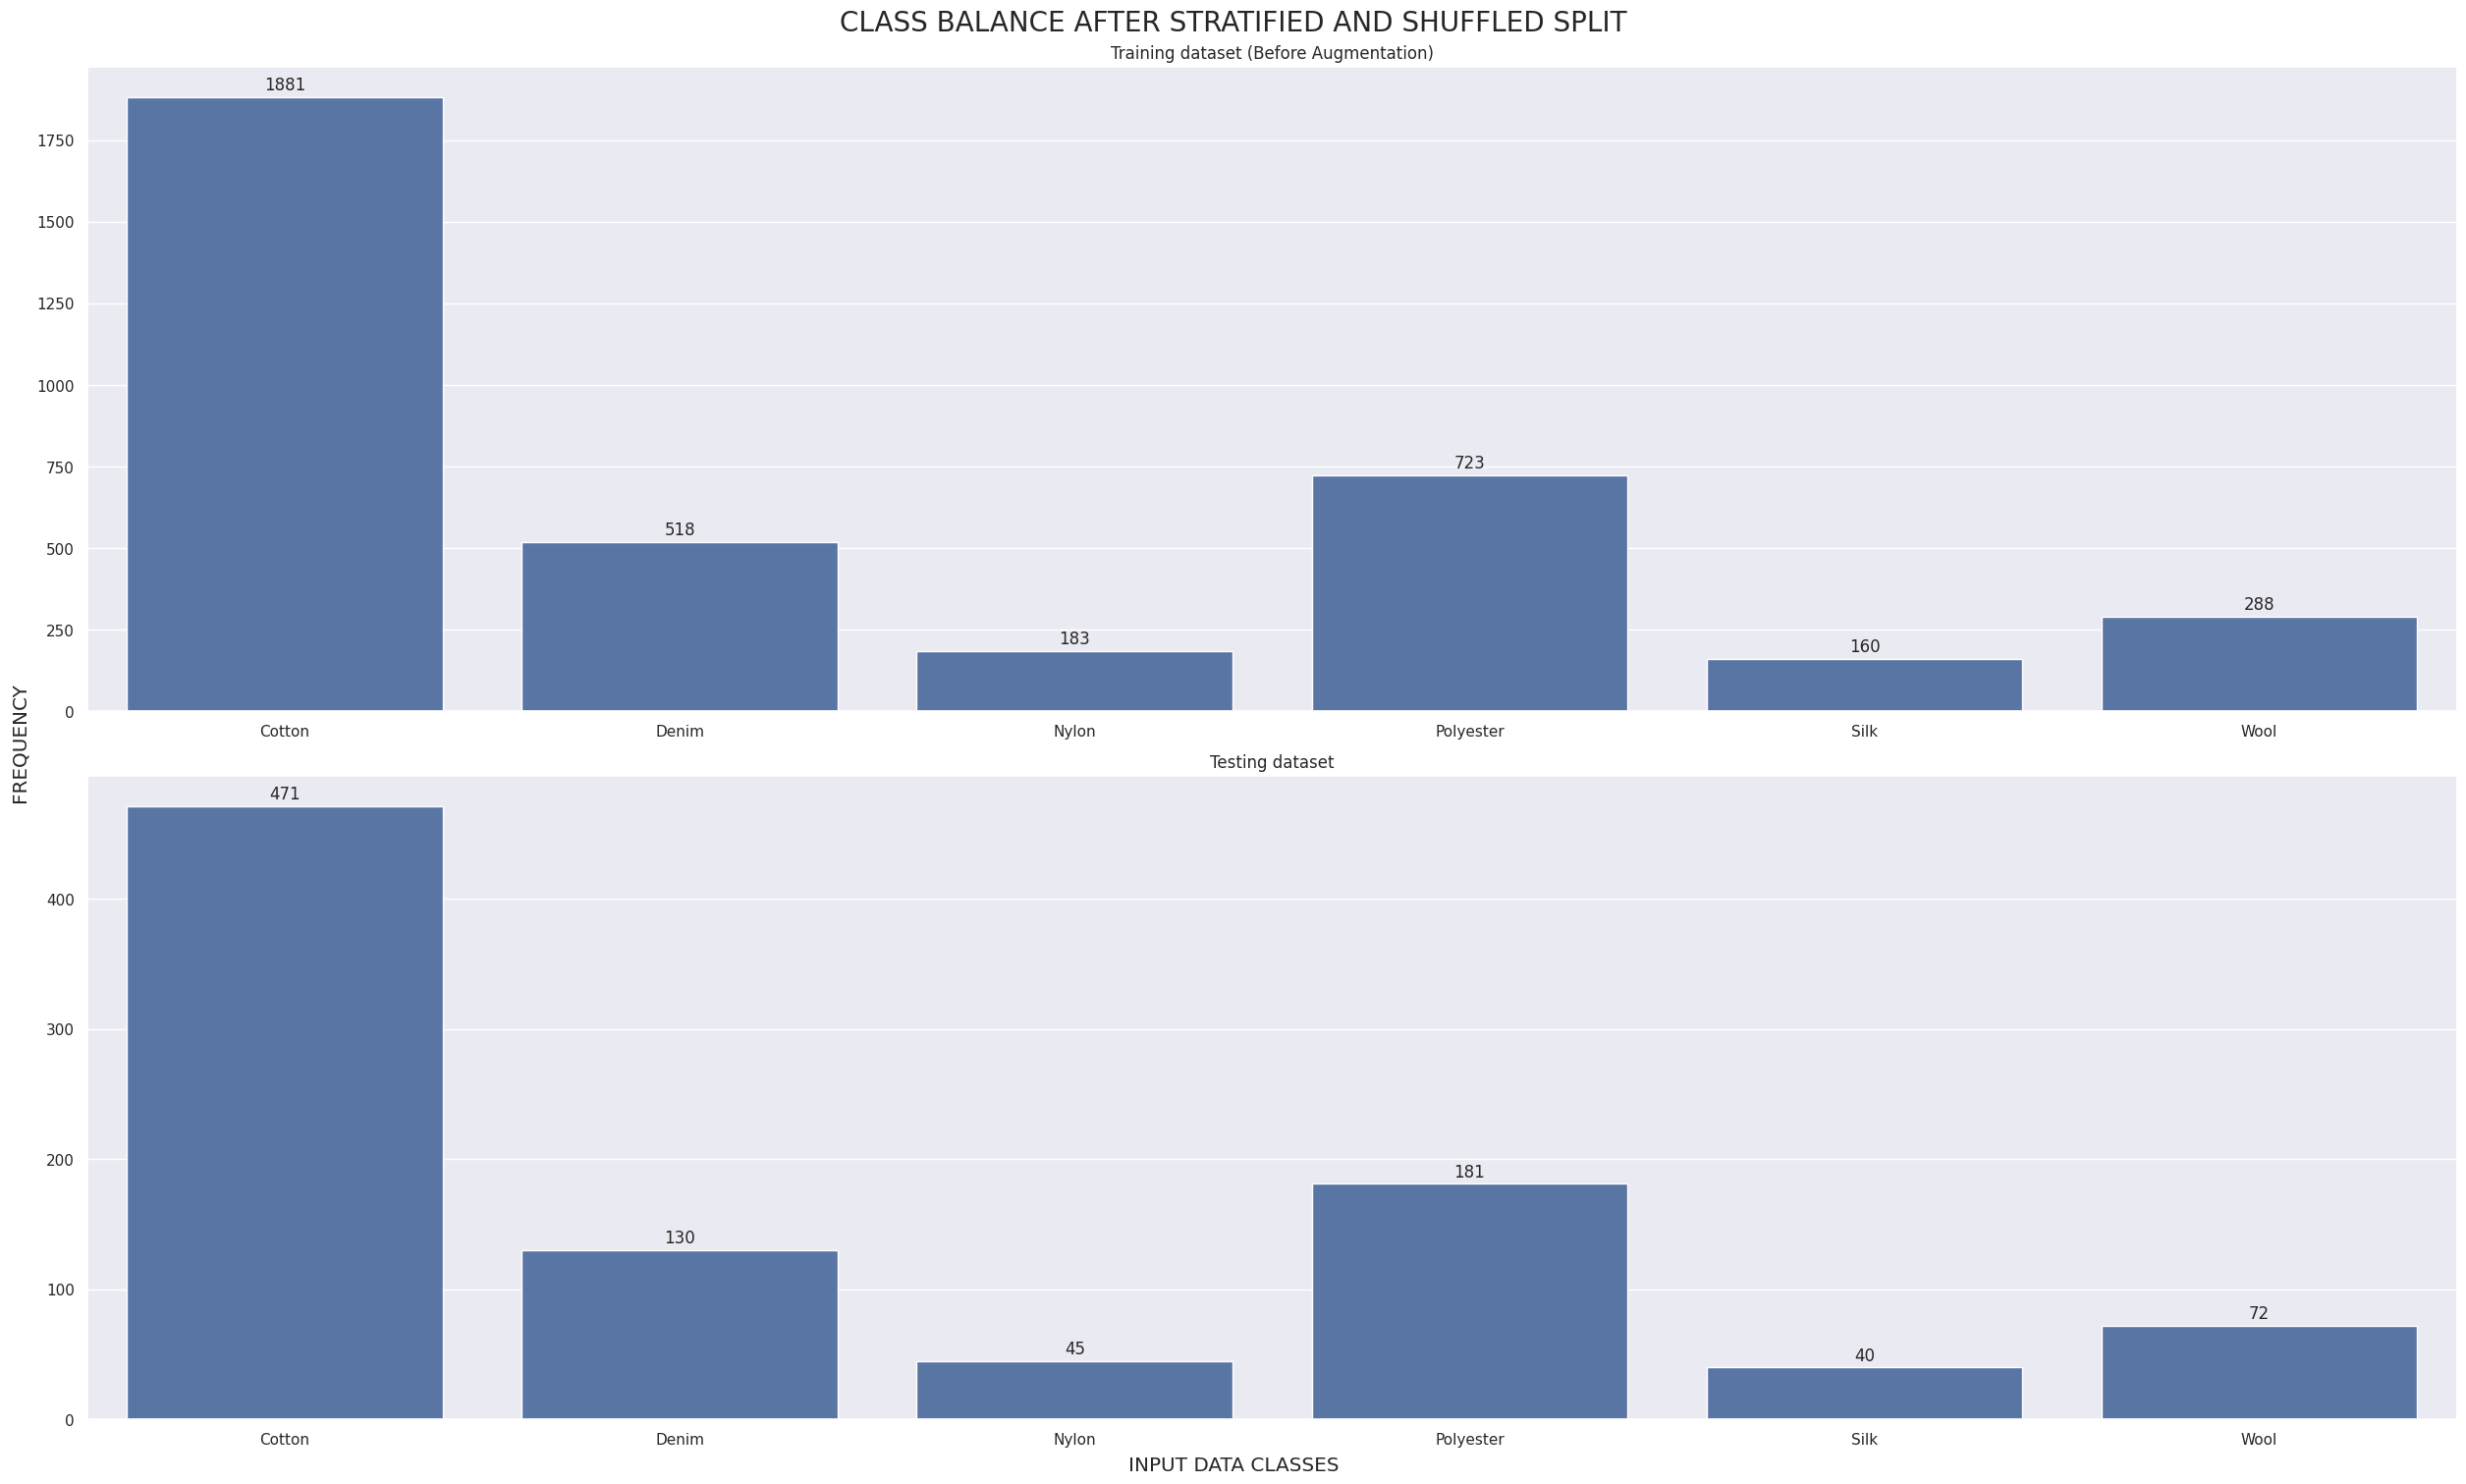

In [95]:
# Class balance after stratify split
fig, axs = plt.subplots(2, 1, figsize=(25,15), layout='constrained')
fig.suptitle('CLASS BALANCE AFTER STRATIFIED AND SHUFFLED SPLIT', fontsize=20)
fig.supxlabel('INPUT DATA CLASSES')
fig.supylabel('FREQUENCY')
axs_list = axs.flatten()

# Class count in training dataset
train_values, train_counts = np.unique(train_df['Label'].tolist(), return_counts=True)
sns.barplot(ax=axs_list[0], x=train_values, y=train_counts).set(title='Training dataset (Before Augmentation)')
ax = axs_list[0]
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

# Class count in testing dataset
test_values, test_counts = np.unique(test_df['Label'].tolist(), return_counts=True)
sns.barplot(ax=axs_list[1], x=test_values, y=test_counts).set(title='Testing dataset')
ax = axs_list[1]
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

plt.show()

In [107]:
# Augmentation level 1
TARGET_DIRECTORY = f"{cur_dir}/preprocessing/augmented/"
original_datagenerator = ImageDataGenerator(rotation_range=30,
                                      width_shift_range=0.1,
                                      height_shift_range=0.1,
                                      shear_range=0.2,
                                      zoom_range=0.1,
                                      horizontal_flip=True,
                                      fill_mode='nearest')


for label in ["Denim", "Nylon", "Polyester", "Silk", "Wool"]:
    os.makedirs(TARGET_DIRECTORY + label)
    temp_df = train_df.loc[train_df['Label'].isin([label])]
    data_gen = original_datagenerator.flow_from_dataframe(
        dataframe = temp_df,
        save_to_dir = TARGET_DIRECTORY + label,
        x_col='Filepath',
        y_col='Label',
        target_size=(400, 400),
        interpolation='bicubic',
        color_mode='rgb',
        class_mode='categorical',
        batch_size=len(temp_df),
        seed=SEED_VALUE,
    )

    # Iterate over the generator to create augmented images
    for _ in data_gen:  # Use '_' as a throwaway variable since we don't need the actual values
        print("Using the Generator to create augmented images")
        break  # Exit the loop after the first batch, as all images are generated in one batch

Found 518 validated image filenames belonging to 1 classes.
Using the Generator to create augmented images
Found 183 validated image filenames belonging to 1 classes.
Using the Generator to create augmented images
Found 723 validated image filenames belonging to 1 classes.
Using the Generator to create augmented images
Found 160 validated image filenames belonging to 1 classes.
Using the Generator to create augmented images
Found 288 validated image filenames belonging to 1 classes.
Using the Generator to create augmented images


In [108]:
# Augmentation level 2
TARGET_DIRECTORY = f"{cur_dir}/preprocessing/augmented_2/"

original_datagenerator = ImageDataGenerator(rotation_range=70,
                                      width_shift_range=0.15,
                                      height_shift_range=0.25,
                                      shear_range=0.1,
                                      zoom_range=0.2,
                                      vertical_flip=True,
                                      fill_mode='nearest')


for label in ["Denim", "Nylon", "Silk", "Wool"]:

    os.makedirs(TARGET_DIRECTORY + label)
    temp_df = train_df.loc[train_df['Label'].isin([label])]
    data_gen = original_datagenerator.flow_from_dataframe(
        dataframe = temp_df,
        save_to_dir = TARGET_DIRECTORY + label,
        x_col='Filepath',
        y_col='Label',
        target_size=(400, 400),
        interpolation='bicubic',
        color_mode='rgb',
        class_mode='categorical',
        batch_size=len(temp_df),
        seed=SEED_VALUE,
    )

  # Iterate over the generator to create augmented images
    for _ in data_gen:  # Use '_' as a throwaway variable since we don't need the actual values
        print("Using the Generator to create augmented images")
        break  # Exit the loop after the first batch, as all images are generated in one batch

Found 518 validated image filenames belonging to 1 classes.
Using the Generator to create augmented images
Found 183 validated image filenames belonging to 1 classes.
Using the Generator to create augmented images
Found 160 validated image filenames belonging to 1 classes.
Using the Generator to create augmented images
Found 288 validated image filenames belonging to 1 classes.
Using the Generator to create augmented images


In [109]:
# Extracting file input directory and labels for the augmented data
AUGMENTED_FILE_PATH = f"{cur_dir}/preprocessing/"

input_filepaths = []
input_labels = []

for augmentation in os.listdir(AUGMENTED_FILE_PATH):
    for fabric in os.listdir(os.path.join(AUGMENTED_FILE_PATH, augmentation)):
        print("In folder {} \n".format(fabric))
        for fabric_img in os.listdir(os.path.join(AUGMENTED_FILE_PATH, augmentation, fabric)):
            if Path(fabric_img).suffix == '.png':
                src_image = os.path.join(AUGMENTED_FILE_PATH, augmentation, fabric, fabric_img)
                input_filepaths.append(src_image)
                input_labels.append(fabric)


# Creating dataframe with the filepath and respective labels
data_df_augmented = pd.DataFrame(list(zip(input_filepaths, input_labels)), columns =['Filepath', 'Label'])
temp_train_df = pd.concat([train_df, data_df_augmented])
temp_train_df = temp_train_df.reset_index(drop=True)
temp_train_df

In folder Denim 

In folder Nylon 

In folder Polyester 

In folder Silk 

In folder Wool 

In folder Denim 

In folder Nylon 

In folder Silk 

In folder Wool 



,Filepath,Label
0,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
1,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
2,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Denim
3,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
4,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Polyester
...,...,...
6769,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
6770,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
6771,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
6772,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool


In [110]:
# Augmentation level 3
TARGET_DIRECTORY = f"{cur_dir}/preprocessing/augmented_3/"
original_datagenerator = ImageDataGenerator(rotation_range=10,
                                      shear_range=0.15,
                                      zoom_range=[0.5,1.0],
                                      brightness_range=[0.2,1.0],
                                      vertical_flip=True,
                                      fill_mode='nearest')
for label in ["Nylon", "Silk", "Wool"]:

    os.makedirs(TARGET_DIRECTORY + label)
    temp_df = temp_train_df.loc[temp_train_df['Label'].isin([label])]
    data_gen = original_datagenerator.flow_from_dataframe(
        dataframe = temp_df,
        save_to_dir = TARGET_DIRECTORY + label,
        x_col='Filepath',
        y_col='Label',
        target_size=(400, 400),
        interpolation='bicubic',
        color_mode='rgb',
        class_mode='categorical',
        batch_size=len(temp_df),
        seed=SEED_VALUE,
    )

   # Iterate over the generator to create augmented images
    for _ in data_gen:  # Use '_' as a throwaway variable since we don't need the actual values
        print("Using the Generator to create augmented images")
        break  # Exit the loop after the first batch, as all images are generated in one batch

Found 549 validated image filenames belonging to 1 classes.
Using the Generator to create augmented images
Found 480 validated image filenames belonging to 1 classes.
Using the Generator to create augmented images
Found 864 validated image filenames belonging to 1 classes.
Using the Generator to create augmented images


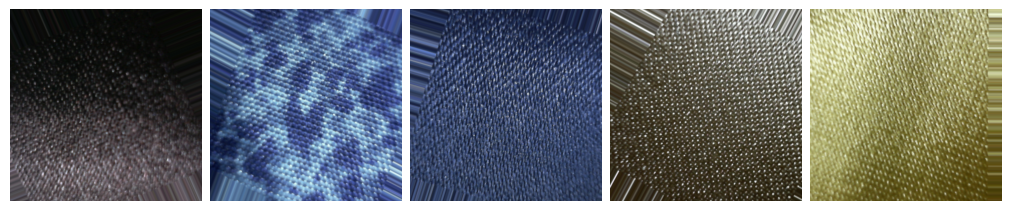

In [111]:
import matplotlib.pyplot as plt
import os

# Đặt đường dẫn đến thư mục "Denim" sau khi tăng cường dữ liệu
DENIM = f"{cur_dir}/preprocessing/augmented/Silk/"

# Tạo đồ thị
plt.figure(figsize=(10, 10), layout='constrained')

# Hiển thị một số hình ảnh của lớp "Denim"
for i, image in enumerate(os.listdir(DENIM)):
    if i == 5:
        break
    ax = plt.subplot(1, 5, i + 1)
    ax.imshow(plt.imread(os.path.join(DENIM, image)))
    plt.axis('off')

# Hiển thị đồ thị

<div class="markdown-google-sans">

### **4.3. Merging the augmented dataset**





In [114]:
import os
from pathlib import Path

# Đặt đường dẫn đến thư mục chứa dữ liệu hình ảnh tăng cường
AUGMENTED_FILE_PATH = f"{cur_dir}/preprocessing/augmented_3"

input_filepaths = []
input_labels = []

# Lặp qua các thư mục và hình ảnh
for fabric in os.listdir(AUGMENTED_FILE_PATH):
    print("In folder {} \n".format(fabric))
    fabric_path = os.path.join(AUGMENTED_FILE_PATH, fabric)
    if os.path.isdir(fabric_path):  # Kiểm tra xem có phải thư mục không
        for fabric_img in os.listdir(fabric_path):
            if Path(fabric_img).suffix == '.png':
                src_image = os.path.join(fabric_path, fabric_img)
                input_filepaths.append(src_image)
                input_labels.append(fabric)


In folder Nylon 

In folder Silk 

In folder Wool 



In [115]:
# Creating dataframe with the filepath and respective labels
data_df_augmented = pd.DataFrame(list(zip(input_filepaths, input_labels)), columns =['Filepath', 'Label'])
data_df_augmented

,Filepath,Label
0,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Nylon
1,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Nylon
2,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Nylon
3,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Nylon
4,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Nylon
...,...,...
1888,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
1889,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
1890,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
1891,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool


In [116]:
train_df = pd.concat([temp_train_df, data_df_augmented])
train_df = train_df.reset_index(drop=True)
train_df

,Filepath,Label
0,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
1,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
2,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Denim
3,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
4,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Polyester
...,...,...
8662,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
8663,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
8664,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
8665,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool


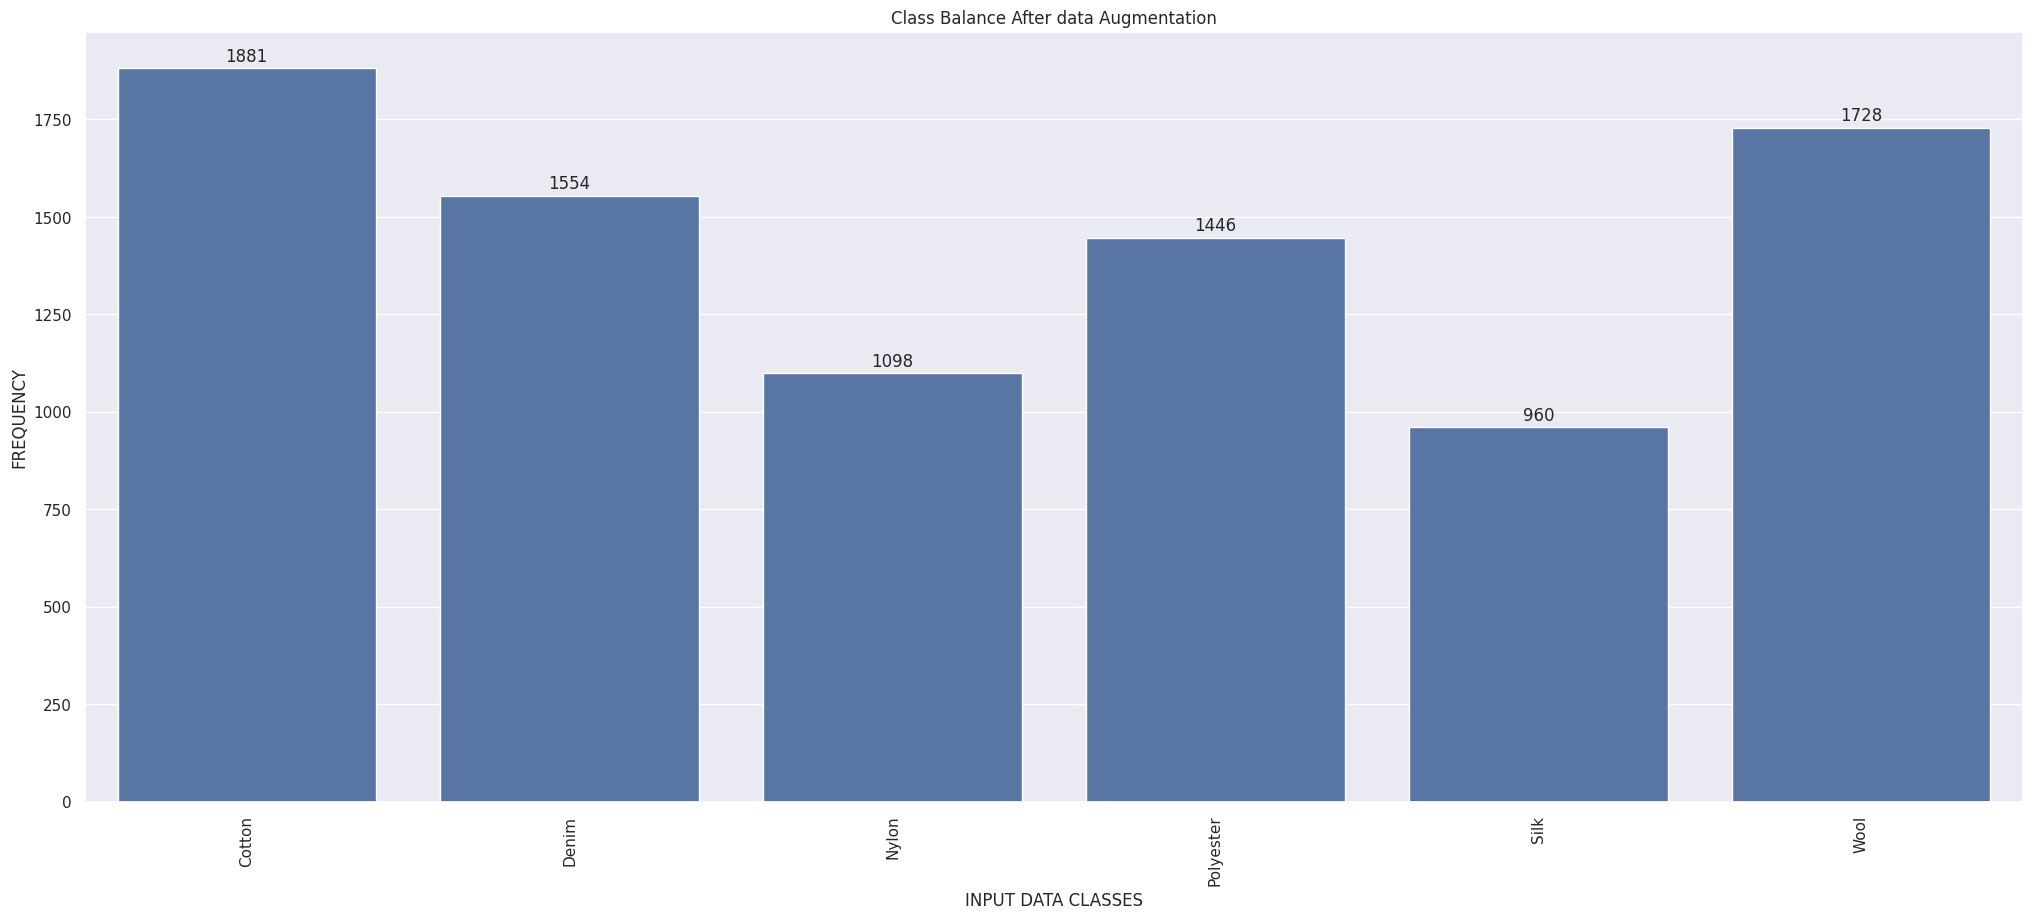

In [117]:
fig, ax = plt.subplots(figsize=(25,10))
values, counts = np.unique(train_df.Label.values.tolist(), return_counts=True)
sns.set_theme()
ax = sns.barplot(x=values, y=counts)
ax.set_title("Class Balance After data Augmentation")
ax.set_xlabel("INPUT DATA CLASSES")
ax.set_ylabel("FREQUENCY")
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

plt.xticks(rotation=90)
plt.show()

### 4.4. Creating Train & Validation Datasets


In [118]:
# Splitting the data into train & test datasets with stratification ; perform a bigger split
train_df, validation_df = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=SEED_VALUE)

In [125]:

train_df.to_csv(f"{cur_dir}/models/data/train.csv", index=False)
validation_df.to_csv(f"{cur_dir}/models/data/validation.csv", index=False)
test_df.to_csv(f"{cur_dir}/models/data/test.csv", index=False)


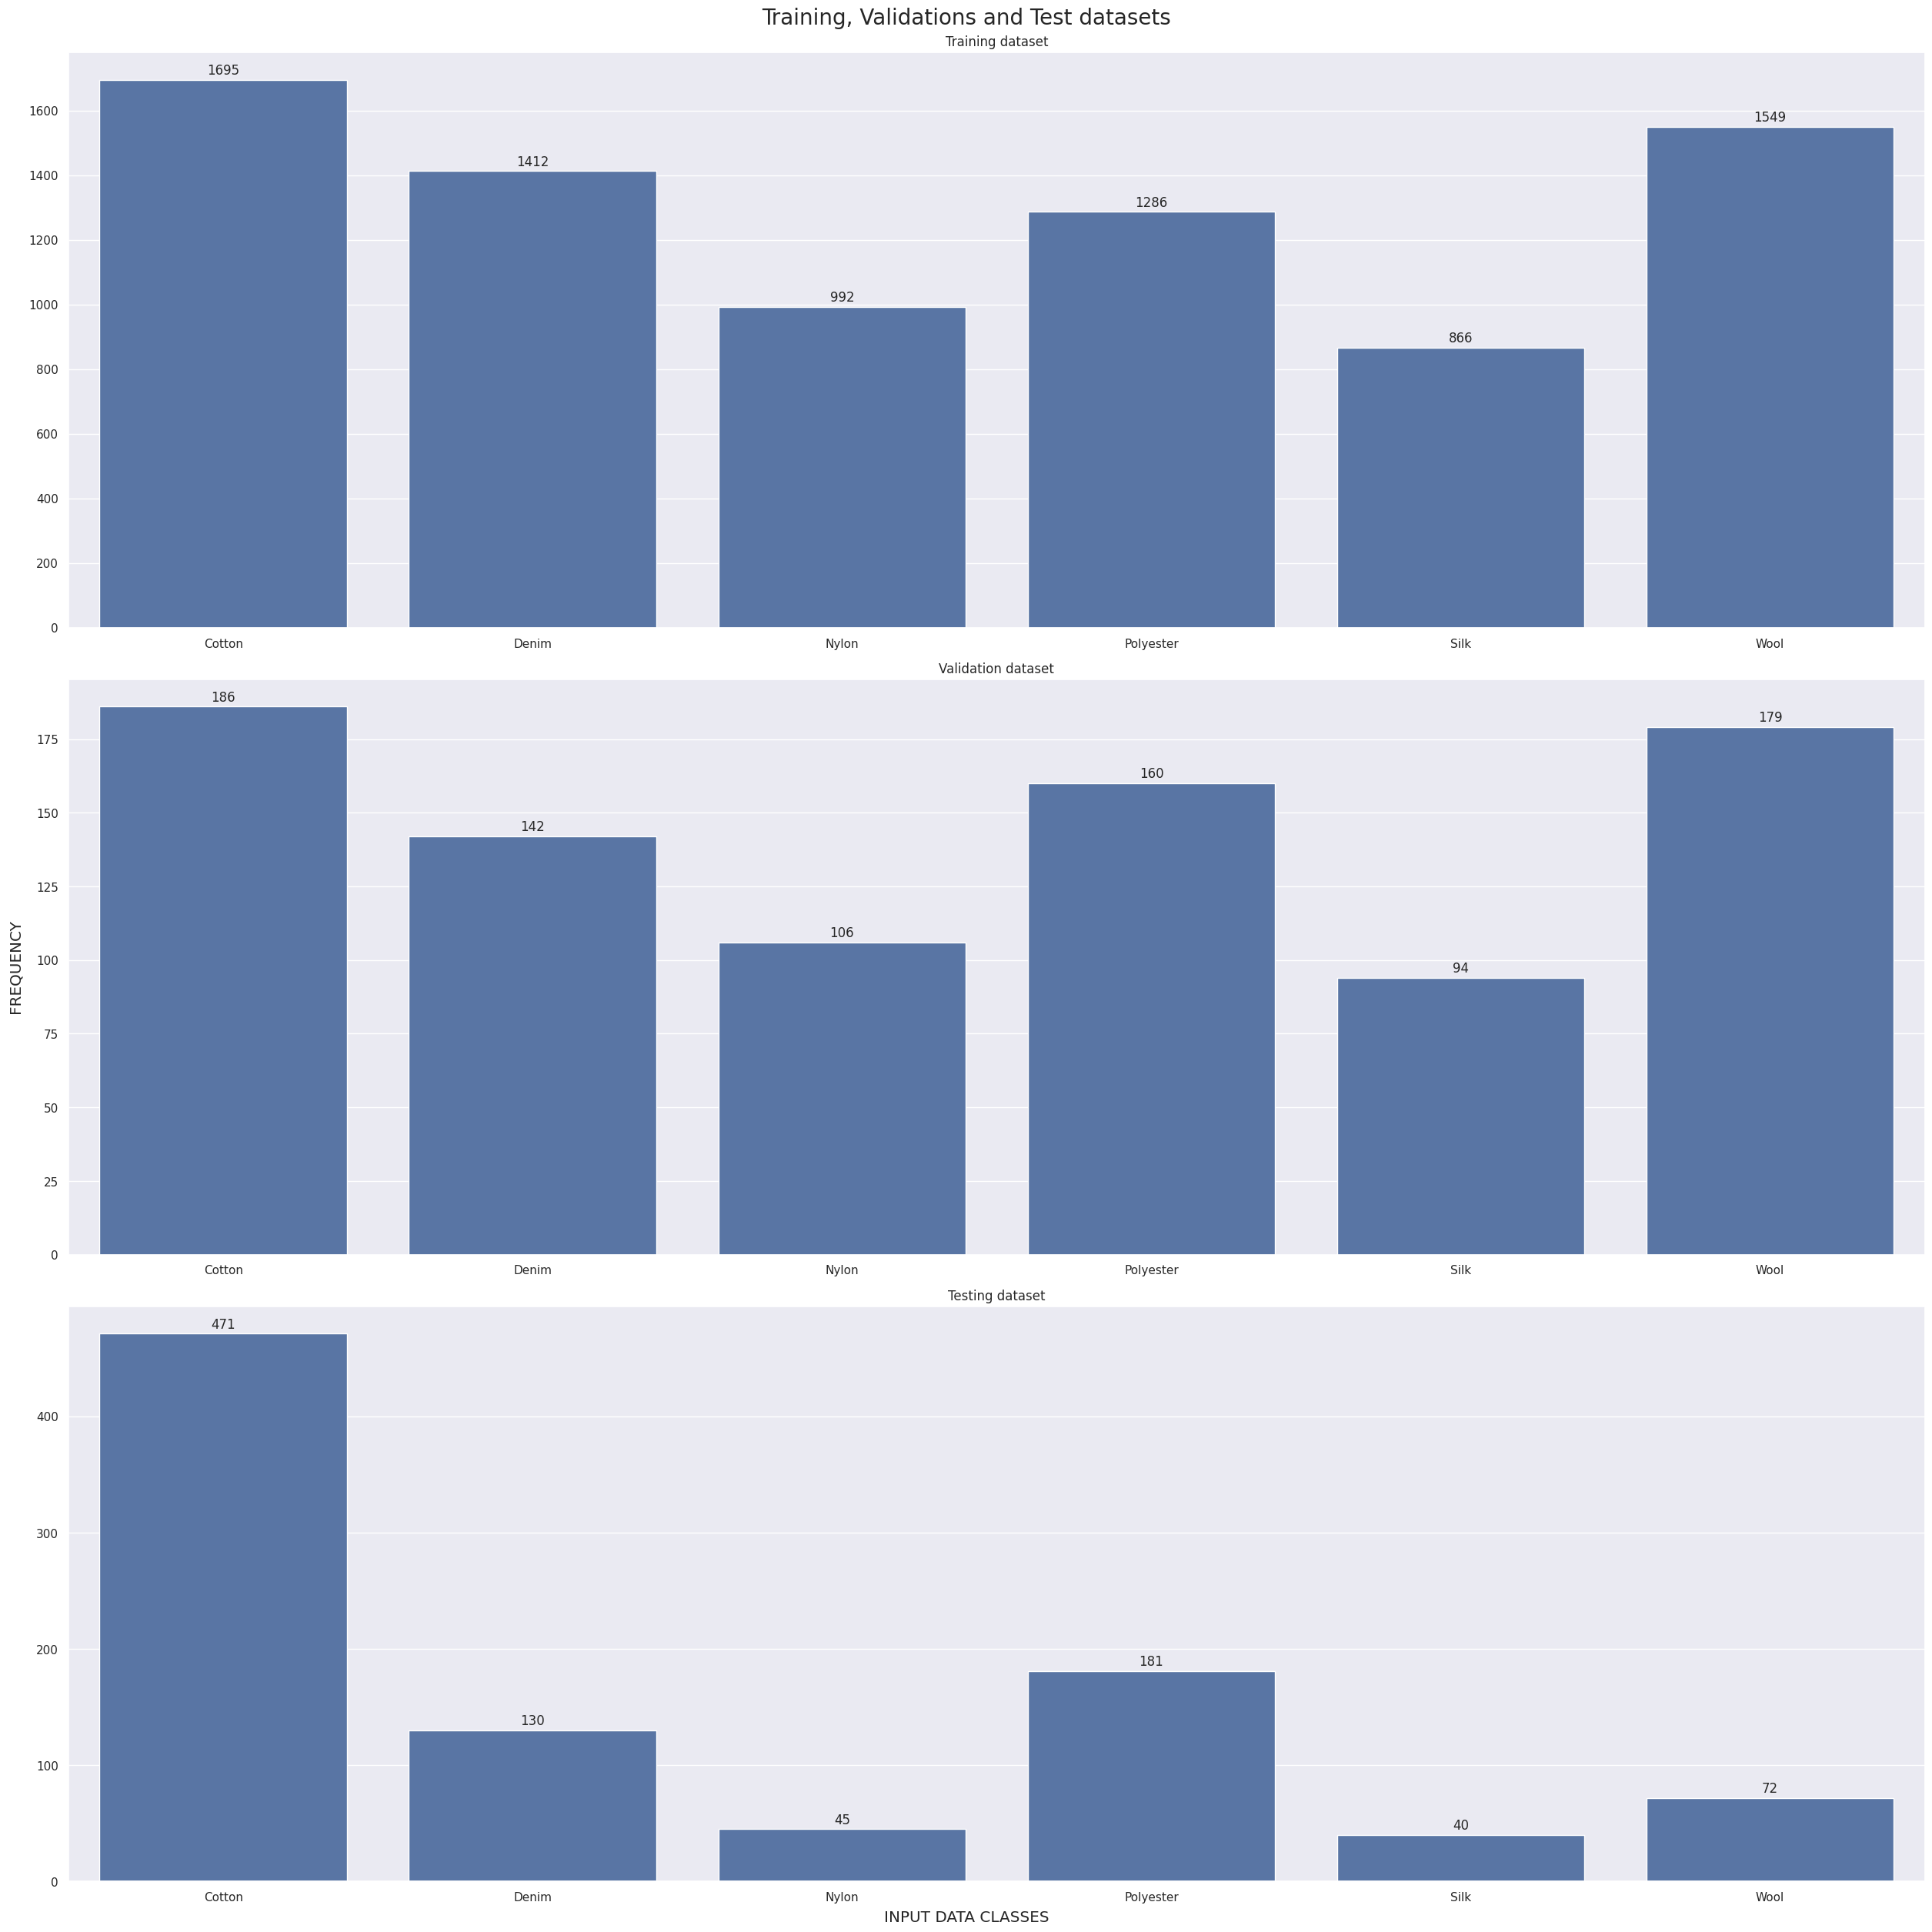

In [120]:
# Class balance after stratify split
fig, axs = plt.subplots(3, 1, figsize=(25,25), layout='constrained')
fig.suptitle('Training, Validations and Test datasets', fontsize=20)
fig.supxlabel('INPUT DATA CLASSES')
fig.supylabel('FREQUENCY')
axs_list = axs.flatten()

# Class count in training dataset
train_values, train_counts = np.unique(train_df['Label'].tolist(), return_counts=True)
sns.barplot(ax=axs_list[0], x=train_values, y=train_counts).set(title='Training dataset')
ax=ax=axs_list[0]
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

# Class count in validation dataset
validation_values, validation_counts = np.unique(validation_df['Label'].tolist(), return_counts=True)
sns.barplot(ax=axs_list[1], x=validation_values, y=validation_counts).set(title='Validation dataset')
ax=ax=axs_list[1]
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

# Class count in testing dataset
test_values, test_counts = np.unique(test_df['Label'].tolist(), return_counts=True)
sns.barplot(ax=axs_list[2], x=test_values, y=test_counts).set(title='Testing dataset')
ax=ax=axs_list[2]
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'), (g.get_x() + g.get_width() / 2., g.get_height()), ha = 'center', va = 'center', xytext = (0, 9),
                   textcoords = 'offset points')

plt.show()

# END